# Projeto 11: Transfer learning para identificação de objetos  

- Neste projeto, vamos utilizar uma rede neural pré-treinada chamada MobileNet
- Utilizaremos a base de dados TensorFlow Flowers 
- Código baseado na documentação abaixo: 
https://www.tensorflow.org/beta/tutorials/images/hub_with_keras


# Etapa 1: Importação das bibliotecas

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import zipfile
tf.__version__

'2.8.0'

In [3]:
!pip install tensorflow_hub --upgrade
import tensorflow_hub as hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Etapa 2: Importação do modelo pré-treinado

In [4]:
trained_MobileNet_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" 

In [5]:
trained_MobileNet = tf.keras.Sequential([hub.KerasLayer(trained_MobileNet_url, 
                                                        input_shape=(224,224,3))])

# Etapa 3: Testes com o modelo pré-treinado

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
path = "/content/drive/My Drive/Deep learning/Transfer-Learning-Data.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [8]:
#redimensão
sample_image= tf.keras.preprocessing.image.load_img(r'/content/Transfer Learning Data/watch.jpg', 
                                                    target_size = (224, 224))

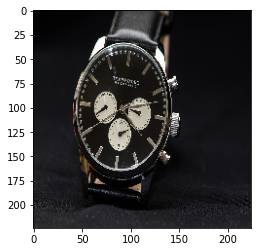

In [9]:
plt.imshow(sample_image)

In [10]:
#normalização
sample_image = np.array(sample_image) / 255.0

In [11]:
sample_image.shape

(224, 224, 3)

In [12]:
#batch
predicted_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis = 0))

In [13]:
predicted_class

array([[ 0.31979933,  0.72271794, -0.46497577, ...,  0.253696  ,
        -1.4674318 , -0.0016138 ]], dtype=float32)

In [14]:
len(predicted_class[0])

1001

In [15]:
predicted_class.shape

(1, 1001)

In [16]:
predicted_class = np.argmax(predicted_class)
predicted_class

827

In [17]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [18]:
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [19]:
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [20]:
len(imagenet_labels)

1001

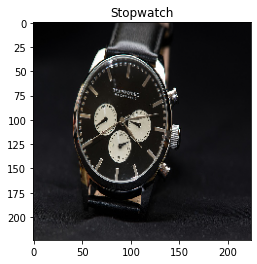

In [21]:
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[predicted_class]
plt.title(predicted_class_name.title());

# Etapa 4: Testes com um conjunto de imagens

In [22]:
#base de dados de imagens
flowers_data_url = tf.keras.utils.get_file('flower_photos', 
                                           'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                            untar=True)

In [23]:
#normalização
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

flower_data = image_generator.flow_from_directory(str(flowers_data_url),
                                                  target_size=(224,224),
                                                  batch_size=64,
                                                  shuffle=True)

Found 3670 images belonging to 5 classes.


In [24]:
for flowers_data_input_batch, flowers_data_label_batch in flower_data:
  print("Image batch shape: ", flowers_data_input_batch.shape)
  print("Label batch shape: ", flowers_data_label_batch.shape)
  break

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)


In [25]:
predictions_batch = trained_MobileNet.predict(flowers_data_input_batch)
predictions_batch.shape

(64, 1001)

In [26]:
predicted_class_names = imagenet_labels[np.argmax(predictions_batch, axis=-1)]
predicted_class_names

array(['conch', 'plate rack', 'bee', 'mushroom', 'vase', 'fountain',
       'cardoon', 'daisy', 'quill', 'ant', 'cardoon', 'picket fence',
       'daisy', 'daisy', 'picket fence', 'brass', 'feather boa',
       'plastic bag', 'daisy', 'spotlight', 'daisy', 'pot', 'vase',
       'mask', 'orange', 'lacewing', 'vase', 'daisy', 'cardoon', 'daisy',
       'microwave', 'flamingo', 'ant', 'daisy', 'sea urchin',
       'cabbage butterfly', 'picket fence', 'greenhouse', 'bell pepper',
       'cardoon', 'daisy', 'daisy', 'ringlet', 'daisy', 'daisy',
       'greenhouse', "yellow lady's slipper", 'daisy', 'daisy', 'orange',
       'shield', 'bonnet', 'ringlet', 'artichoke', 'vase', 'cardoon',
       'orange', 'vase', 'balloon', 'daisy', 'picket fence',
       'plastic bag', 'fountain', 'American egret'], dtype='<U30')

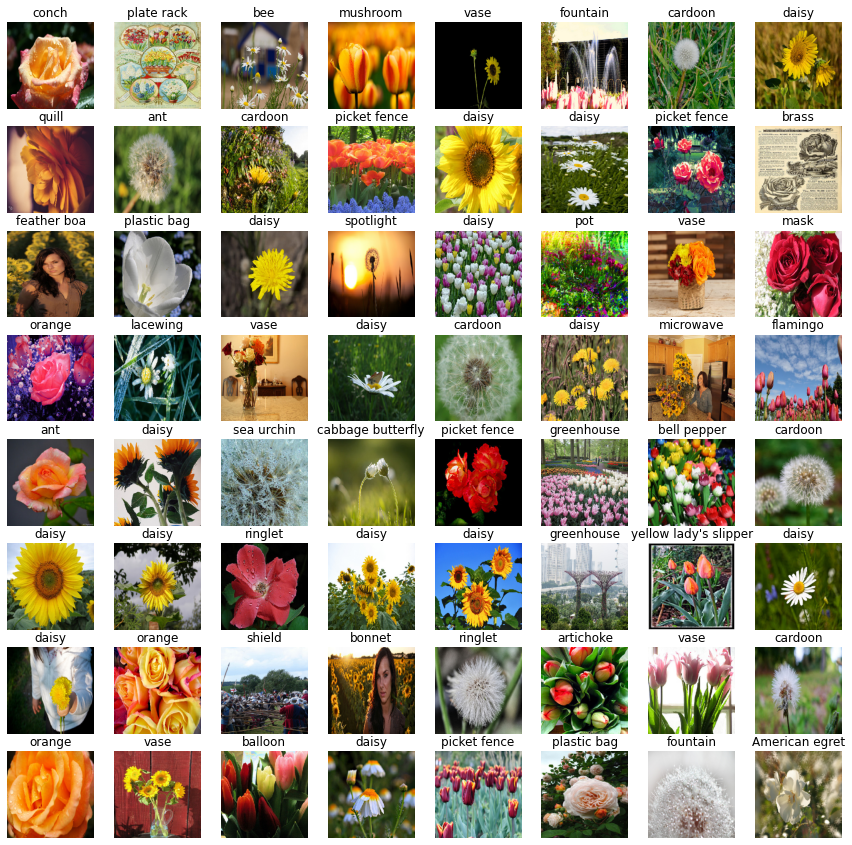

In [27]:
plt.figure(figsize=(15,15))
for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

# Etapa 5: Transfer learning

Download do MobileNet sem o topo do modelo:
https://tfhub.dev/s?module-type=image-feature-vector&q=tf2


In [28]:
#extrator de caracteristicas
MobileNet_feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [29]:
MobileNet_feature_extractor_layer = hub.KerasLayer(MobileNet_feature_extractor_url,
                                                   input_shape=(224, 224, 3))

In [30]:
#150528 -> 1280 com os feature extractor
feature_batch = MobileNet_feature_extractor_layer(flowers_data_input_batch)
feature_batch.shape

TensorShape([64, 1280])

In [31]:
MobileNet_feature_extractor_layer.trainable = False

In [32]:
flower_data.num_classes

5

In [44]:
#soft max na saida
model = tf.keras.Sequential([MobileNet_feature_extractor_layer,
                             tf.keras.layers.Dense(flower_data.num_classes, activation='softmax')])


In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [46]:
predictions = model(flowers_data_input_batch)
predictions.shape

TensorShape([64, 5])

In [48]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
history = model.fit(flower_data, epochs=50)

Epoch 1/50
58/58 [==============================] - 14s 215ms/step - loss: 0.7797 - accuracy: 0.7101
Epoch 2/50
58/58 [==============================] - 13s 215ms/step - loss: 0.3839 - accuracy: 0.8703
Epoch 3/50
58/58 [==============================] - 13s 215ms/step - loss: 0.3063 - accuracy: 0.9005
Epoch 4/50
58/58 [==============================] - 12s 214ms/step - loss: 0.2643 - accuracy: 0.9174
Epoch 5/50
58/58 [==============================] - 12s 213ms/step - loss: 0.2350 - accuracy: 0.9305
Epoch 6/50
58/58 [==============================] - 12s 212ms/step - loss: 0.2094 - accuracy: 0.9379
Epoch 7/50
58/58 [==============================] - 12s 214ms/step - loss: 0.1877 - accuracy: 0.9493
Epoch 8/50
58/58 [==============================] - 13s 227ms/step - loss: 0.1740 - accuracy: 0.9520
Epoch 9/50
58/58 [==============================] - 13s 215ms/step - loss: 0.1590 - accuracy: 0.9564
Epoch 10/50
58/58 [==============================] - 13s 215ms/step - loss: 0.1478 - accura

# Etapa 6: Avaliação do modelo

In [51]:
class_names = sorted(flower_data.class_indices.items(), key = lambda pair:pair[1])

In [52]:
class_names

[('daisy', 0),
 ('dandelion', 1),
 ('roses', 2),
 ('sunflowers', 3),
 ('tulips', 4)]

In [53]:
class_names = np.array([key.title() for key, value in class_names])

In [54]:
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [55]:
predicted_batch = model.predict(flowers_data_input_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [56]:
predicted_id

array([2, 2, 0, 4, 3, 4, 1, 3, 2, 1, 1, 4, 3, 0, 2, 2, 3, 4, 1, 1, 4, 4,
       2, 2, 2, 0, 2, 0, 1, 1, 3, 4, 2, 3, 1, 0, 2, 4, 4, 1, 3, 3, 2, 3,
       3, 4, 4, 0, 1, 2, 2, 3, 1, 4, 4, 1, 2, 3, 4, 0, 4, 2, 1, 2])

In [57]:
predicted_label_batch

array(['Roses', 'Roses', 'Daisy', 'Tulips', 'Sunflowers', 'Tulips',
       'Dandelion', 'Sunflowers', 'Roses', 'Dandelion', 'Dandelion',
       'Tulips', 'Sunflowers', 'Daisy', 'Roses', 'Roses', 'Sunflowers',
       'Tulips', 'Dandelion', 'Dandelion', 'Tulips', 'Tulips', 'Roses',
       'Roses', 'Roses', 'Daisy', 'Roses', 'Daisy', 'Dandelion',
       'Dandelion', 'Sunflowers', 'Tulips', 'Roses', 'Sunflowers',
       'Dandelion', 'Daisy', 'Roses', 'Tulips', 'Tulips', 'Dandelion',
       'Sunflowers', 'Sunflowers', 'Roses', 'Sunflowers', 'Sunflowers',
       'Tulips', 'Tulips', 'Daisy', 'Dandelion', 'Roses', 'Roses',
       'Sunflowers', 'Dandelion', 'Tulips', 'Tulips', 'Dandelion',
       'Roses', 'Sunflowers', 'Tulips', 'Daisy', 'Tulips', 'Roses',
       'Dandelion', 'Roses'], dtype='<U10')

In [58]:
label_id = np.argmax(flowers_data_label_batch, axis=-1)
label_id

array([2, 2, 0, 4, 3, 4, 1, 3, 2, 1, 1, 4, 3, 0, 2, 2, 3, 4, 1, 1, 4, 4,
       2, 2, 2, 0, 2, 0, 1, 1, 3, 4, 2, 3, 1, 0, 2, 4, 4, 1, 3, 3, 2, 3,
       3, 4, 4, 0, 1, 2, 2, 3, 1, 4, 4, 1, 2, 3, 4, 0, 4, 2, 1, 2])

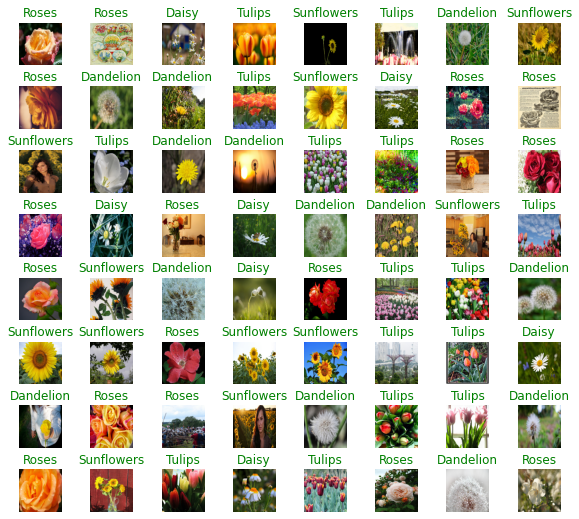

In [59]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

#verde é certo e vermelho errado(acertou todas no batch)
for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')